In [201]:
import numpy as np
import pandas as pd
import itertools as it

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import roc_curve, auc, roc_auc_score

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

order_new = pd.read_csv("orders_new.csv")
order_product_prior = pd.read_csv("order_products_prior.csv")


In [202]:
us_feature2 = pd.read_csv("../model_data/up_feature2.csv")
us_feature2

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order
0,1,196,10,176.0,17.600000,59,18,0.333333,10,1,10,1.400000,35791,0.582500,2.0,0.223520,5.900000,1.000000,0,1.000000
1,1,10258,10,176.0,17.600000,59,18,0.333333,9,2,10,3.333333,1946,0.552962,2.0,0.286228,5.900000,0.900000,0,1.000000
2,1,10326,10,176.0,17.600000,59,18,0.333333,1,5,5,5.000000,5526,0.521581,2.0,0.347991,5.900000,0.100000,5,0.166667
3,1,12427,10,176.0,17.600000,59,18,0.333333,10,1,10,3.300000,6476,0.529482,2.0,0.259265,5.900000,1.000000,0,1.000000
4,1,13032,10,176.0,17.600000,59,18,0.333333,3,2,10,6.333333,3751,0.479782,2.0,0.342842,5.900000,0.300000,0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,206209,43961,13,210.0,16.153846,129,68,0.586207,3,4,12,8.000000,55371,0.514642,2.0,0.369417,9.923077,0.230769,1,0.300000
13307949,206209,44325,13,210.0,16.153846,129,68,0.586207,1,7,7,8.000000,3485,0.289890,2.0,0.598852,9.923077,0.076923,6,0.142857
13307950,206209,48370,13,210.0,16.153846,129,68,0.586207,1,11,11,8.000000,3934,0.592561,2.0,0.300712,9.923077,0.076923,2,0.333333
13307951,206209,48697,13,210.0,16.153846,129,68,0.586207,1,7,7,6.000000,9783,0.260662,2.0,0.642339,9.923077,0.076923,6,0.142857


In [203]:
order_new

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set
0,2539329,1,1,2,8,NaN,prior
1,2398795,1,2,3,7,15.0,prior
2,473747,1,3,3,12,21.0,prior
3,2254736,1,4,4,7,29.0,prior
4,431534,1,5,4,15,28.0,prior
...,...,...,...,...,...,...,...
3421078,2266710,206209,10,5,18,29.0,prior
3421079,1854736,206209,11,4,10,30.0,prior
3421080,626363,206209,12,1,12,18.0,prior
3421081,2977660,206209,13,1,12,7.0,prior


In [204]:
order_new[order_new["eval_set"] == "train"]

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set
10,1187899,1,11,4,8,14.0,train
25,1492625,2,15,1,11,30.0,train
49,2196797,5,5,0,11,6.0,train
74,525192,7,21,2,11,6.0,train
78,880375,8,4,1,14,10.0,train
...,...,...,...,...,...,...,...
3420838,2585586,206199,20,2,16,30.0,train
3420862,943915,206200,24,6,19,6.0,train
3420924,2371631,206203,6,4,19,30.0,train
3420933,1716008,206205,4,1,16,10.0,train


In [205]:
order_new[order_new["eval_set"] == "test"]

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set
38,2774568,3,13,5,15,11.0,test
44,329954,4,6,3,12,30.0,test
53,1528013,6,4,3,16,22.0,test
96,1376945,11,8,6,11,8.0,test
102,1356845,12,6,1,20,30.0,test
...,...,...,...,...,...,...,...
3420918,2728930,206202,23,2,17,6.0,test
3420929,350108,206204,5,4,14,14.0,test
3421001,1043943,206206,68,0,20,0.0,test
3421018,2821651,206207,17,2,13,14.0,test


In [206]:
order_new[order_new["eval_set"] == "prior"]

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set
0,2539329,1,1,2,8,NaN,prior
1,2398795,1,2,3,7,15.0,prior
2,473747,1,3,3,12,21.0,prior
3,2254736,1,4,4,7,29.0,prior
4,431534,1,5,4,15,28.0,prior
...,...,...,...,...,...,...,...
3421077,2558525,206209,9,4,15,22.0,prior
3421078,2266710,206209,10,5,18,29.0,prior
3421079,1854736,206209,11,4,10,30.0,prior
3421080,626363,206209,12,1,12,18.0,prior


In [207]:
order_new = order_new[order_new["eval_set"] != "prior" ]
order_new

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set
10,1187899,1,11,4,8,14.0,train
25,1492625,2,15,1,11,30.0,train
38,2774568,3,13,5,15,11.0,test
44,329954,4,6,3,12,30.0,test
49,2196797,5,5,0,11,6.0,train
...,...,...,...,...,...,...,...
3420933,1716008,206205,4,1,16,10.0,train
3421001,1043943,206206,68,0,20,0.0,test
3421018,2821651,206207,17,2,13,14.0,test
3421068,803273,206208,50,5,11,4.0,test


In [208]:
order_new = order_new.drop(["order_number", "order_dow", "order_hour_of_day", "days_since_prior_order"], axis=1)
order_new

,order_id,user_id,eval_set
10,1187899,1,train
25,1492625,2,train
38,2774568,3,test
44,329954,4,test
49,2196797,5,train
...,...,...,...
3420933,1716008,206205,train
3421001,1043943,206206,test
3421018,2821651,206207,test
3421068,803273,206208,test


### Based on the dataframe created in feature engineering 2, left join with the orders_new table (you just need column user_id and eval_set) where the orders are not from the prior eval_set. 

In [209]:
us_feature2 = pd.merge(us_feature2, order_new, how="left", on="user_id")
us_feature2

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,order_id,eval_set
0,1,196,10,176.0,17.600000,59,18,0.333333,10,1,...,35791,0.582500,2.0,0.223520,5.900000,1.000000,0,1.000000,1187899,train
1,1,10258,10,176.0,17.600000,59,18,0.333333,9,2,...,1946,0.552962,2.0,0.286228,5.900000,0.900000,0,1.000000,1187899,train
2,1,10326,10,176.0,17.600000,59,18,0.333333,1,5,...,5526,0.521581,2.0,0.347991,5.900000,0.100000,5,0.166667,1187899,train
3,1,12427,10,176.0,17.600000,59,18,0.333333,10,1,...,6476,0.529482,2.0,0.259265,5.900000,1.000000,0,1.000000,1187899,train
4,1,13032,10,176.0,17.600000,59,18,0.333333,3,2,...,3751,0.479782,2.0,0.342842,5.900000,0.300000,0,0.333333,1187899,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,206209,43961,13,210.0,16.153846,129,68,0.586207,3,4,...,55371,0.514642,2.0,0.369417,9.923077,0.230769,1,0.300000,272231,train
13307949,206209,44325,13,210.0,16.153846,129,68,0.586207,1,7,...,3485,0.289890,2.0,0.598852,9.923077,0.076923,6,0.142857,272231,train
13307950,206209,48370,13,210.0,16.153846,129,68,0.586207,1,11,...,3934,0.592561,2.0,0.300712,9.923077,0.076923,2,0.333333,272231,train
13307951,206209,48697,13,210.0,16.153846,129,68,0.586207,1,7,...,9783,0.260662,2.0,0.642339,9.923077,0.076923,6,0.142857,272231,train


###  Split the dataset into two, one for train and one for test based on column eval_set

In [210]:
train = us_feature2[us_feature2["eval_set"] == "train"]
test = us_feature2[us_feature2["eval_set"] == "test"]

In [211]:
train

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,order_id,eval_set
0,1,196,10,176.0,17.600000,59,18,0.333333,10,1,...,35791,0.582500,2.0,0.223520,5.900000,1.000000,0,1.000000,1187899,train
1,1,10258,10,176.0,17.600000,59,18,0.333333,9,2,...,1946,0.552962,2.0,0.286228,5.900000,0.900000,0,1.000000,1187899,train
2,1,10326,10,176.0,17.600000,59,18,0.333333,1,5,...,5526,0.521581,2.0,0.347991,5.900000,0.100000,5,0.166667,1187899,train
3,1,12427,10,176.0,17.600000,59,18,0.333333,10,1,...,6476,0.529482,2.0,0.259265,5.900000,1.000000,0,1.000000,1187899,train
4,1,13032,10,176.0,17.600000,59,18,0.333333,3,2,...,3751,0.479782,2.0,0.342842,5.900000,0.300000,0,0.333333,1187899,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,206209,43961,13,210.0,16.153846,129,68,0.586207,3,4,...,55371,0.514642,2.0,0.369417,9.923077,0.230769,1,0.300000,272231,train
13307949,206209,44325,13,210.0,16.153846,129,68,0.586207,1,7,...,3485,0.289890,2.0,0.598852,9.923077,0.076923,6,0.142857,272231,train
13307950,206209,48370,13,210.0,16.153846,129,68,0.586207,1,11,...,3934,0.592561,2.0,0.300712,9.923077,0.076923,2,0.333333,272231,train
13307951,206209,48697,13,210.0,16.153846,129,68,0.586207,1,7,...,9783,0.260662,2.0,0.642339,9.923077,0.076923,6,0.142857,272231,train


### Left join with order_products_new table where eval_set is train, the reordered column will be the target varaible, set the value for reordered column to be 0 for products that are not ordered in the most recent order.

In [212]:
order_product_new = pd.read_csv("../model_data/order_products_new.csv")
order_product_new

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
33819101,3421063,14233,3,1
33819102,3421063,35548,4,1
33819103,3421070,35951,1,1
33819104,3421070,16953,2,1


In [213]:
order_new

,order_id,user_id,eval_set
10,1187899,1,train
25,1492625,2,train
38,2774568,3,test
44,329954,4,test
49,2196797,5,train
...,...,...,...
3420933,1716008,206205,train
3421001,1043943,206206,test
3421018,2821651,206207,test
3421068,803273,206208,test


In [214]:
order_train = order_new[order_new["eval_set"] == "train"]
order_test = order_new[order_new["eval_set"] == "test"]
join = pd.merge(order_train, order_product_new, on="order_id", how="left")

In [215]:
join

,order_id,user_id,eval_set,product_id,add_to_cart_order,reordered
0,1187899,1,train,196,1,1
1,1187899,1,train,25133,2,1
2,1187899,1,train,38928,3,1
3,1187899,1,train,26405,4,1
4,1187899,1,train,39657,5,1
...,...,...,...,...,...,...
1384612,272231,206209,train,40603,4,0
1384613,272231,206209,train,15655,5,0
1384614,272231,206209,train,42606,6,0
1384615,272231,206209,train,37966,7,0


In [216]:
order_train = pd.DataFrame({"user_id": join["user_id"], 
                            "product_id": join["product_id"], 
                            "reordered": join["reordered"]})

In [217]:
order_train["reordered"].isna().sum()

0

In [218]:
order_train

,user_id,product_id,reordered
0,1,196,1
1,1,25133,1
2,1,38928,1
3,1,26405,1
4,1,39657,1
...,...,...,...
1384612,206209,40603,0
1384613,206209,15655,0
1384614,206209,42606,0
1384615,206209,37966,0


In [219]:
order_train["reordered"].value_counts()

1    828824
0    555793
Name: reordered, dtype: int64

In [220]:
train

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,order_id,eval_set
0,1,196,10,176.0,17.600000,59,18,0.333333,10,1,...,35791,0.582500,2.0,0.223520,5.900000,1.000000,0,1.000000,1187899,train
1,1,10258,10,176.0,17.600000,59,18,0.333333,9,2,...,1946,0.552962,2.0,0.286228,5.900000,0.900000,0,1.000000,1187899,train
2,1,10326,10,176.0,17.600000,59,18,0.333333,1,5,...,5526,0.521581,2.0,0.347991,5.900000,0.100000,5,0.166667,1187899,train
3,1,12427,10,176.0,17.600000,59,18,0.333333,10,1,...,6476,0.529482,2.0,0.259265,5.900000,1.000000,0,1.000000,1187899,train
4,1,13032,10,176.0,17.600000,59,18,0.333333,3,2,...,3751,0.479782,2.0,0.342842,5.900000,0.300000,0,0.333333,1187899,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,206209,43961,13,210.0,16.153846,129,68,0.586207,3,4,...,55371,0.514642,2.0,0.369417,9.923077,0.230769,1,0.300000,272231,train
13307949,206209,44325,13,210.0,16.153846,129,68,0.586207,1,7,...,3485,0.289890,2.0,0.598852,9.923077,0.076923,6,0.142857,272231,train
13307950,206209,48370,13,210.0,16.153846,129,68,0.586207,1,11,...,3934,0.592561,2.0,0.300712,9.923077,0.076923,2,0.333333,272231,train
13307951,206209,48697,13,210.0,16.153846,129,68,0.586207,1,7,...,9783,0.260662,2.0,0.642339,9.923077,0.076923,6,0.142857,272231,train


In [221]:
final = pd.merge(train, order_train, how="left")

In [222]:
final

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,order_id,eval_set,reordered
0,1,196,10,176.0,17.600000,59,18,0.333333,10,1,...,0.582500,2.0,0.223520,5.900000,1.000000,0,1.000000,1187899,train,1.0
1,1,10258,10,176.0,17.600000,59,18,0.333333,9,2,...,0.552962,2.0,0.286228,5.900000,0.900000,0,1.000000,1187899,train,1.0
2,1,10326,10,176.0,17.600000,59,18,0.333333,1,5,...,0.521581,2.0,0.347991,5.900000,0.100000,5,0.166667,1187899,train,NaN
3,1,12427,10,176.0,17.600000,59,18,0.333333,10,1,...,0.529482,2.0,0.259265,5.900000,1.000000,0,1.000000,1187899,train,NaN
4,1,13032,10,176.0,17.600000,59,18,0.333333,3,2,...,0.479782,2.0,0.342842,5.900000,0.300000,0,0.333333,1187899,train,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209,43961,13,210.0,16.153846,129,68,0.586207,3,4,...,0.514642,2.0,0.369417,9.923077,0.230769,1,0.300000,272231,train,NaN
8474657,206209,44325,13,210.0,16.153846,129,68,0.586207,1,7,...,0.289890,2.0,0.598852,9.923077,0.076923,6,0.142857,272231,train,NaN
8474658,206209,48370,13,210.0,16.153846,129,68,0.586207,1,11,...,0.592561,2.0,0.300712,9.923077,0.076923,2,0.333333,272231,train,NaN
8474659,206209,48697,13,210.0,16.153846,129,68,0.586207,1,7,...,0.260662,2.0,0.642339,9.923077,0.076923,6,0.142857,272231,train,NaN


In [223]:
final["eval_set"].unique()

array(['train'], dtype=object)

In [224]:
final["reordered"] = final["reordered"].fillna(0)

In [225]:
final["reordered"].unique()

array([1., 0.])

In [226]:
final = final.drop("eval_set", axis=1)
final

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,order_id,reordered
0,1,196,10,176.0,17.600000,59,18,0.333333,10,1,...,35791,0.582500,2.0,0.223520,5.900000,1.000000,0,1.000000,1187899,1.0
1,1,10258,10,176.0,17.600000,59,18,0.333333,9,2,...,1946,0.552962,2.0,0.286228,5.900000,0.900000,0,1.000000,1187899,1.0
2,1,10326,10,176.0,17.600000,59,18,0.333333,1,5,...,5526,0.521581,2.0,0.347991,5.900000,0.100000,5,0.166667,1187899,0.0
3,1,12427,10,176.0,17.600000,59,18,0.333333,10,1,...,6476,0.529482,2.0,0.259265,5.900000,1.000000,0,1.000000,1187899,0.0
4,1,13032,10,176.0,17.600000,59,18,0.333333,3,2,...,3751,0.479782,2.0,0.342842,5.900000,0.300000,0,0.333333,1187899,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209,43961,13,210.0,16.153846,129,68,0.586207,3,4,...,55371,0.514642,2.0,0.369417,9.923077,0.230769,1,0.300000,272231,0.0
8474657,206209,44325,13,210.0,16.153846,129,68,0.586207,1,7,...,3485,0.289890,2.0,0.598852,9.923077,0.076923,6,0.142857,272231,0.0
8474658,206209,48370,13,210.0,16.153846,129,68,0.586207,1,11,...,3934,0.592561,2.0,0.300712,9.923077,0.076923,2,0.333333,272231,0.0
8474659,206209,48697,13,210.0,16.153846,129,68,0.586207,1,7,...,9783,0.260662,2.0,0.642339,9.923077,0.076923,6,0.142857,272231,0.0


In [227]:
sample_df = final.sample(frac=0.1, random_state=99)
sample_df

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,order_id,reordered
8091908,196719,30827,19,246.0,12.947368,262,135,0.579399,1,2,...,13571,0.552011,2.0,0.274851,13.789474,0.052632,17,0.055556,478890,0.0
4354404,105500,7485,19,246.0,12.947368,291,83,0.295374,5,3,...,8179,0.429192,2.0,0.422179,15.315789,0.263158,7,0.294118,1803356,0.0
1058380,25683,35418,8,198.0,24.750000,170,116,0.743590,1,2,...,534,0.350806,2.0,0.464419,21.250000,0.125000,6,0.142857,1287003,0.0
2303133,56102,43379,20,212.0,10.600000,126,73,0.608333,1,18,...,608,0.357664,2.0,0.450658,6.300000,0.050000,2,0.333333,1968351,0.0
6289206,153033,44479,36,253.0,7.027778,296,125,0.464684,2,19,...,7924,0.463729,2.0,0.372287,8.222222,0.055556,7,0.111111,1401017,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7846324,190738,6046,17,208.0,12.235294,197,102,0.536842,2,16,...,22590,0.507640,2.0,0.336078,11.588235,0.117647,0,1.000000,1568915,0.0
6508888,158376,1202,35,336.0,9.600000,414,127,0.324808,1,28,...,4376,0.431544,2.0,0.417276,11.828571,0.028571,7,0.125000,531700,0.0
7874115,191443,7388,73,360.0,4.931507,1146,163,0.143866,8,6,...,3783,0.457080,2.0,0.360296,15.698630,0.109589,30,0.117647,787191,0.0
1207454,29431,25146,6,103.0,17.166667,25,24,1.090909,1,1,...,24918,0.454087,2.0,0.365800,4.166667,0.166667,5,0.166667,670313,0.0


## Apply in full data and predict probability

In [229]:
order_test = order_new[order_new["eval_set"] == "test"]
order_test

,order_id,user_id,eval_set
38,2774568,3,test
44,329954,4,test
53,1528013,6,test
96,1376945,11,test
102,1356845,12,test
...,...,...,...
3420918,2728930,206202,test
3420929,350108,206204,test
3421001,1043943,206206,test
3421018,2821651,206207,test


In [230]:
order_product_new

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
33819101,3421063,14233,3,1
33819102,3421063,35548,4,1
33819103,3421070,35951,1,1
33819104,3421070,16953,2,1


In [231]:
test_join = pd.merge(order_test, order_product_new, on="order_id", how="left")
test_join

,order_id,user_id,eval_set,product_id,add_to_cart_order,reordered
0,2774568,3,test,NaN,NaN,NaN
1,329954,4,test,NaN,NaN,NaN
2,1528013,6,test,NaN,NaN,NaN
3,1376945,11,test,NaN,NaN,NaN
4,1356845,12,test,NaN,NaN,NaN
...,...,...,...,...,...,...
74995,2728930,206202,test,NaN,NaN,NaN
74996,350108,206204,test,NaN,NaN,NaN
74997,1043943,206206,test,NaN,NaN,NaN
74998,2821651,206207,test,NaN,NaN,NaN


In [232]:
test_join['reordered'] = test_join['reordered'].fillna(0)
test_join

,order_id,user_id,eval_set,product_id,add_to_cart_order,reordered
0,2774568,3,test,NaN,NaN,0.0
1,329954,4,test,NaN,NaN,0.0
2,1528013,6,test,NaN,NaN,0.0
3,1376945,11,test,NaN,NaN,0.0
4,1356845,12,test,NaN,NaN,0.0
...,...,...,...,...,...,...
74995,2728930,206202,test,NaN,NaN,0.0
74996,350108,206204,test,NaN,NaN,0.0
74997,1043943,206206,test,NaN,NaN,0.0
74998,2821651,206207,test,NaN,NaN,0.0


In [233]:
order_test = pd.DataFrame({"user_id": test_join["user_id"], 
                            "product_id": test_join["product_id"], 
                            "reordered": test_join["reordered"]})

In [234]:
order_test

,user_id,product_id,reordered
0,3,NaN,0.0
1,4,NaN,0.0
2,6,NaN,0.0
3,11,NaN,0.0
4,12,NaN,0.0
...,...,...,...
74995,206202,NaN,0.0
74996,206204,NaN,0.0
74997,206206,NaN,0.0
74998,206207,NaN,0.0


In [235]:
test_final = pd.merge(test, order_test, how="left")

In [236]:
test_final

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,order_id,eval_set,reordered
0,3,248,12,133.0,11.083333,88,33,0.423077,1,2,...,0.279508,2.0,0.599749,7.333333,0.083333,10,0.090909,2774568,test,NaN
1,3,1005,12,133.0,11.083333,88,33,0.423077,1,10,...,0.312741,2.0,0.559395,7.333333,0.083333,2,0.333333,2774568,test,NaN
2,3,1819,12,133.0,11.083333,88,33,0.423077,3,4,...,0.346872,2.0,0.507838,7.333333,0.250000,5,0.333333,2774568,test,NaN
3,3,7503,12,133.0,11.083333,88,33,0.423077,1,3,...,0.383731,2.0,0.446449,7.333333,0.083333,9,0.100000,2774568,test,NaN
4,3,8021,12,133.0,11.083333,88,33,0.423077,1,2,...,0.440836,2.0,0.408843,7.333333,0.083333,10,0.090909,2774568,test,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,206208,48364,49,357.0,7.285714,677,198,0.297744,1,3,...,0.412092,2.0,0.469873,13.816327,0.020408,46,0.021277,803273,test,NaN
4833288,206208,48865,49,357.0,7.285714,677,198,0.297744,1,42,...,0.294239,2.0,0.605985,13.816327,0.020408,7,0.125000,803273,test,NaN
4833289,206208,49247,49,357.0,7.285714,677,198,0.297744,1,6,...,0.486424,2.0,0.345359,13.816327,0.020408,43,0.022727,803273,test,NaN
4833290,206208,49385,49,357.0,7.285714,677,198,0.297744,1,27,...,0.157088,2.0,0.820755,13.816327,0.020408,22,0.043478,803273,test,NaN


In [237]:
test_final = test_final.drop(['eval_set'], axis=1)
test_final

,user_id,product_id,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,...,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,order_id,reordered
0,3,248,12,133.0,11.083333,88,33,0.423077,1,2,...,6371,0.279508,2.0,0.599749,7.333333,0.083333,10,0.090909,2774568,NaN
1,3,1005,12,133.0,11.083333,88,33,0.423077,1,10,...,463,0.312741,2.0,0.559395,7.333333,0.083333,2,0.333333,2774568,NaN
2,3,1819,12,133.0,11.083333,88,33,0.423077,3,4,...,2424,0.346872,2.0,0.507838,7.333333,0.250000,5,0.333333,2774568,NaN
3,3,7503,12,133.0,11.083333,88,33,0.423077,1,3,...,12474,0.383731,2.0,0.446449,7.333333,0.083333,9,0.100000,2774568,NaN
4,3,8021,12,133.0,11.083333,88,33,0.423077,1,2,...,27864,0.440836,2.0,0.408843,7.333333,0.083333,10,0.090909,2774568,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,206208,48364,49,357.0,7.285714,677,198,0.297744,1,3,...,19501,0.412092,2.0,0.469873,13.816327,0.020408,46,0.021277,803273,NaN
4833288,206208,48865,49,357.0,7.285714,677,198,0.297744,1,42,...,802,0.294239,2.0,0.605985,13.816327,0.020408,7,0.125000,803273,NaN
4833289,206208,49247,49,357.0,7.285714,677,198,0.297744,1,6,...,6292,0.486424,2.0,0.345359,13.816327,0.020408,43,0.022727,803273,NaN
4833290,206208,49385,49,357.0,7.285714,677,198,0.297744,1,27,...,318,0.157088,2.0,0.820755,13.816327,0.020408,22,0.043478,803273,NaN


In [239]:
test_final = test_final.drop(['reordered','user_id', 'product_id'], axis=1)
test_final

,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,order_id
0,12,133.0,11.083333,88,33,0.423077,1,2,2,3.000000,6371,0.279508,2.0,0.599749,7.333333,0.083333,10,0.090909,2774568
1,12,133.0,11.083333,88,33,0.423077,1,10,10,5.000000,463,0.312741,2.0,0.559395,7.333333,0.083333,2,0.333333,2774568
2,12,133.0,11.083333,88,33,0.423077,3,4,7,2.666667,2424,0.346872,2.0,0.507838,7.333333,0.250000,5,0.333333,2774568
3,12,133.0,11.083333,88,33,0.423077,1,3,3,6.000000,12474,0.383731,2.0,0.446449,7.333333,0.083333,9,0.100000,2774568
4,12,133.0,11.083333,88,33,0.423077,1,2,2,5.000000,27864,0.440836,2.0,0.408843,7.333333,0.083333,10,0.090909,2774568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,49,357.0,7.285714,677,198,0.297744,1,3,3,9.000000,19501,0.412092,2.0,0.469873,13.816327,0.020408,46,0.021277,803273
4833288,49,357.0,7.285714,677,198,0.297744,1,42,42,7.000000,802,0.294239,2.0,0.605985,13.816327,0.020408,7,0.125000,803273
4833289,49,357.0,7.285714,677,198,0.297744,1,6,6,11.000000,6292,0.486424,2.0,0.345359,13.816327,0.020408,43,0.022727,803273
4833290,49,357.0,7.285714,677,198,0.297744,1,27,27,7.000000,318,0.157088,2.0,0.820755,13.816327,0.020408,22,0.043478,803273


In [240]:
final = final.drop(['user_id', 'product_id'], axis=1)
final

,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,order_id,reordered
0,10,176.0,17.600000,59,18,0.333333,10,1,10,1.400000,35791,0.582500,2.0,0.223520,5.900000,1.000000,0,1.000000,1187899,1.0
1,10,176.0,17.600000,59,18,0.333333,9,2,10,3.333333,1946,0.552962,2.0,0.286228,5.900000,0.900000,0,1.000000,1187899,1.0
2,10,176.0,17.600000,59,18,0.333333,1,5,5,5.000000,5526,0.521581,2.0,0.347991,5.900000,0.100000,5,0.166667,1187899,0.0
3,10,176.0,17.600000,59,18,0.333333,10,1,10,3.300000,6476,0.529482,2.0,0.259265,5.900000,1.000000,0,1.000000,1187899,0.0
4,10,176.0,17.600000,59,18,0.333333,3,2,10,6.333333,3751,0.479782,2.0,0.342842,5.900000,0.300000,0,0.333333,1187899,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,13,210.0,16.153846,129,68,0.586207,3,4,12,8.000000,55371,0.514642,2.0,0.369417,9.923077,0.230769,1,0.300000,272231,0.0
8474657,13,210.0,16.153846,129,68,0.586207,1,7,7,8.000000,3485,0.289890,2.0,0.598852,9.923077,0.076923,6,0.142857,272231,0.0
8474658,13,210.0,16.153846,129,68,0.586207,1,11,11,8.000000,3934,0.592561,2.0,0.300712,9.923077,0.076923,2,0.333333,272231,0.0
8474659,13,210.0,16.153846,129,68,0.586207,1,7,7,6.000000,9783,0.260662,2.0,0.642339,9.923077,0.076923,6,0.142857,272231,0.0


In [241]:
best_param = {
        'booster':'gbtree',
        'objective':'binary:logistic',
        'gamma':0.5, 
        'max_depth':6,
        'lambda':4, 
        'subsample':0.9,
        'min_child_weight':8, 
        'eval_metric':'auc',
        'eta': 0.1,
        'seed':1000,
        'nthread':6
    }

In [245]:
X_train = final.drop(["reordered"], axis=1)
y_train = final['reordered']

In [246]:
xgb_train = xgb.DMatrix(data=X_train,label=y_train)
xgb_test = xgb.DMatrix(data=test_final)

In [247]:
xg_model = xgb.train(params=best_param, 
                     dtrain=xgb_train, 
                     num_boost_round=157, 
                     early_stopping_rounds=30,
                     evals=[(xgb_train, "train_evalset")],
                     verbose_eval=False)

In [248]:
probability = xg_model.predict(xgb_test)
probability

array([0.02646873, 0.06230196, 0.09219345, ..., 0.00675838, 0.00477416,
       0.01176699], dtype=float32)

In [256]:
train_pro = xg_model.predict(xgb_train)
train_pro

array([0.8769301 , 0.79236484, 0.06010384, ..., 0.09000692, 0.02013342,
       0.11989132], dtype=float32)

In [251]:
test_final['reordered_probability'] = pd.Series(probability)

In [252]:
test_final

,user_orders,sum_days_since_prior_order,avg_days_since_prior_order,total_products,distinct_products,reordered_ratio,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,user_average_basket,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,order_id,reordered_probability
0,12,133.0,11.083333,88,33,0.423077,1,2,2,3.000000,6371,0.279508,2.0,0.599749,7.333333,0.083333,10,0.090909,2774568,0.026469
1,12,133.0,11.083333,88,33,0.423077,1,10,10,5.000000,463,0.312741,2.0,0.559395,7.333333,0.083333,2,0.333333,2774568,0.062302
2,12,133.0,11.083333,88,33,0.423077,3,4,7,2.666667,2424,0.346872,2.0,0.507838,7.333333,0.250000,5,0.333333,2774568,0.092193
3,12,133.0,11.083333,88,33,0.423077,1,3,3,6.000000,12474,0.383731,2.0,0.446449,7.333333,0.083333,9,0.100000,2774568,0.030845
4,12,133.0,11.083333,88,33,0.423077,1,2,2,5.000000,27864,0.440836,2.0,0.408843,7.333333,0.083333,10,0.090909,2774568,0.034683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,49,357.0,7.285714,677,198,0.297744,1,3,3,9.000000,19501,0.412092,2.0,0.469873,13.816327,0.020408,46,0.021277,803273,0.009351
4833288,49,357.0,7.285714,677,198,0.297744,1,42,42,7.000000,802,0.294239,2.0,0.605985,13.816327,0.020408,7,0.125000,803273,0.021329
4833289,49,357.0,7.285714,677,198,0.297744,1,6,6,11.000000,6292,0.486424,2.0,0.345359,13.816327,0.020408,43,0.022727,803273,0.006758
4833290,49,357.0,7.285714,677,198,0.297744,1,27,27,7.000000,318,0.157088,2.0,0.820755,13.816327,0.020408,22,0.043478,803273,0.004774


### Plot the distribution of train data

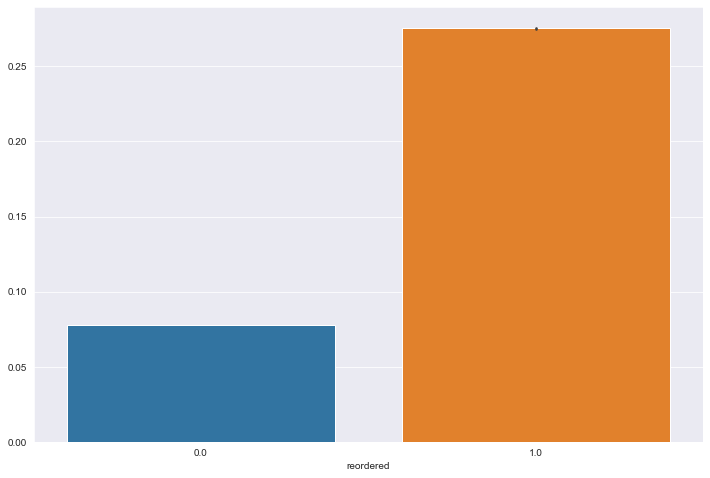

In [257]:
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 8))
sns.barplot(y_train, train_pro)

plt.show()

### Train AUC

In [261]:
[fpr, tpr, thr] = metrics.roc_curve(y_train, train_pro)

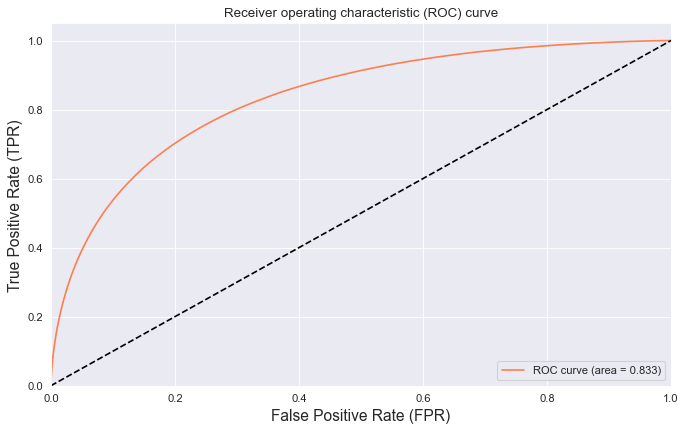

In [262]:
#plot ROC curve
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()